### Dependencies

In [9]:
import os
import shutil
import random
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import Counter

### Stats & Visuals

This code generates bars to visually represent occurences of each class like that of Roboflow

In [2]:
# Define the path where labels are stored

# LABELS_PATHS = ["/home/hghallab/dataset/object_detection_data/RealestRealRaw/train/labels",
#                  "/home/hghallab/dataset/synthetic_data/outputs100/labels",
#                  "/home/hghallab/dataset/synthetic_data/outputs200/labels",
#                  "/home/hghallab/dataset/synthetic_data/outputs250/labels",
#                  "/home/hghallab/dataset/synthetic_data/outputs300/labels"]

LABELS_PATHS = [
    "/home/hghallab/dataset/object_detection_data/FullDataV1/train/labels"
]

In [3]:
# Put classes retireved from label files in a list 
labels = []
for i in range(len(LABELS_PATHS)):
    path = LABELS_PATHS[i]
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        with open(label_path, "r") as file:
            lines = file.readlines()
            for line in lines:
                if int(line[:2]) < 10:
                    labels.append(line[0])
                else:
                    labels.append(line[:2])

In [4]:
# Count the number of instances for each classes 
occurrences = Counter(labels)

# Sort occurrences by count in descending order.
sorted_occurrences = occurrences.most_common()

# Find the maximum count for scaling the bars.
max_count = max(occurrences.values(), default=1) 

# Print the header.
print(" Element | Count | Bar")
print("-" * 30)

# Iterate over occurrences and print bars.
for element, count in sorted_occurrences:
    bar = "*" * int(count * 30 // max_count)
    print(f"{element:8} | {count:5} | {bar}")


 Element | Count | Bar
------------------------------
23       |   663 | ******************************
42       |   553 | *************************
13       |   467 | *********************
59       |   398 | ******************
11       |   387 | *****************
43       |   374 | ****************
38       |   333 | ***************
6        |   317 | **************
29       |   316 | **************
16       |   312 | **************
49       |   298 | *************
3        |   298 | *************
62       |   292 | *************
15       |   291 | *************
7        |   291 | *************
21       |   289 | *************
34       |   289 | *************
22       |   285 | ************
66       |   285 | ************
50       |   282 | ************
12       |   280 | ************
4        |   280 | ************
36       |   278 | ************
64       |   278 | ************
45       |   275 | ************
31       |   274 | ************
33       |   272 | ************
27       | 

Make a historgram

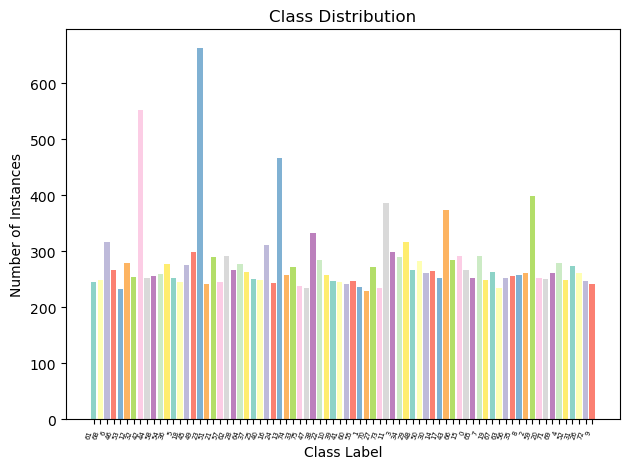

In [22]:
class_labels = list(occurrences.keys())
class_counts = list(occurrences.values())

# Create a colormap object
palette = sns.color_palette("Set3", n_colors=len(class_labels))

# Normalize class indices for color assignment (0 to 1 range)
norm = plt.Normalize(min(range(len(class_labels))), max(range(len(class_labels))))

# Create the bar plot with colors
plt.bar(class_labels, class_counts, color=palette)
plt.xlabel("Class Label")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.xticks(rotation=70, ha='right', fontsize='5')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Generate a heatmap

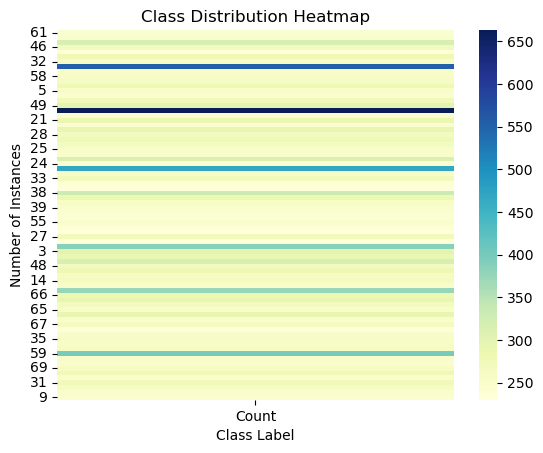

In [8]:
# Create a pandas DataFrame for easier heatmap generation
class_df = pd.DataFrame.from_dict(occurrences, orient='index', columns=['Count'])

# Generate heatmap using pandas and matplotlib/seaborn 
sns.heatmap(class_df, cmap="YlGnBu")  # Y
plt.title("Class Distribution Heatmap")
plt.xlabel("Class Label")
plt.ylabel("Number of Instances")
plt.show()

### Correction of class annotations

I changed the yaml file so I had to corrected each class annotation based on how many classes I removed/modified.

In [74]:
TO_CHANGE_LABELS_PATHS = [
                 "/home/hghallab/dataset/synthetic_data/outputs100/labels",
                 "/home/hghallab/dataset/synthetic_data/outputs200/labels",
                 "/home/hghallab/dataset/synthetic_data/outputs250/labels",
                 "/home/hghallab/dataset/synthetic_data/outputs300/labels"]

In [ ]:
for i in range(0, 4):
    path = TO_CHANGE_LABELS_PATHS[i]
    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        
        with open(label_path, "r") as file:
            lines = file.readlines()
            # print(len(lines) if len(lines)>1 else "", end="")
            for line in lines:
                print("old", line)

                if int(line[:2]) <= 30 and int(line[:2]) >= 15:
                    new_class = int(line[:2]) - 1
                    new_line = str(new_class) + line[2:]

                elif int(line[:2]) <= 62 and int(line[:2]) >= 32:
                    new_class = int(line[:2]) - 2
                    new_line = str(new_class) + line[2:]

                elif int(line[:2]) >= 64:
                    new_class = int(line[:2]) - 3
                    new_line = str(new_class) + line[2:]

                elif int(line[:2]) == 63:
                    new_class = 75
                    new_line = str(new_class) + line[2:]
                
                else:
                    print("no change")
                    new_line = line

                # else:
                #     new_class = int(line[:2])
                print("new", new_line)
        
        with open(label_path, "w") as file:
            file.writelines([new_line])
        # with open(label_path, "w") as file:



### Prepare for training

In this part we're randomly splitting data into train, valid and test data in YOLO format.

In [103]:
# Define directory paths
dir = "/home/hghallab/dataset/object_detection_data/FullDataV1/data"
images_dir = os.path.join(dir, "images")
labels_dir = os.path.join(dir, "labels")
new_train_dir = "/home/hghallab/dataset/object_detection_data/FullDataV1/train"
new_val_dir = "/home/hghallab/dataset/object_detection_data/FullDataV1/valid"
new_test_dir = "/home/hghallab/dataset/object_detection_data/FullDataV1/test"

In [104]:
# Define split ratios (adjust as needed)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [105]:
# Create new directories (if they don't exist)
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)
os.makedirs(os.path.join(new_train_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(new_train_dir, "labels"), exist_ok=True)
os.makedirs(os.path.join(new_val_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(new_val_dir, "labels"), exist_ok=True)
os.makedirs(os.path.join(new_test_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(new_test_dir, "labels"), exist_ok=True)

In [106]:
# Get lists of images and labels (assuming matching filenames)
image_paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]
label_paths = [os.path.join(labels_dir, f) for f in os.listdir(labels_dir)]

In [107]:
# Shuffle combined list (image, label) pairs
combined = list(zip(image_paths, label_paths))
random.shuffle(combined)

In [109]:
# Split data based on ratios
train_split = int(len(combined) * train_ratio)
val_split = train_split + int(len(combined) * val_ratio)

train_data = combined[:train_split]
val_data = combined[train_split:val_split]
test_data = combined[val_split:]


In [111]:
# Move data to respective folders
for image_path, label_path in train_data:
    shutil.move(image_path, os.path.join(new_train_dir, "images", os.path.basename(image_path)))
    shutil.move(label_path, os.path.join(new_train_dir, "labels", os.path.basename(label_path)))

for image_path, label_path in val_data:
    shutil.move(image_path, os.path.join(new_val_dir, "images", os.path.basename(image_path)))
    shutil.move(label_path, os.path.join(new_val_dir, "labels", os.path.basename(label_path)))


for image_path, label_path in test_data:
    shutil.move(image_path, os.path.join(new_test_dir, "images", os.path.basename(image_path)))
    shutil.move(label_path, os.path.join(new_test_dir, "labels", os.path.basename(label_path)))